# NASDAQ 6-Month % Change vs Yield Curve Correlation Analysis

Interactive visualization correlating NASDAQ, S&P 500, Gold, and Silver 6-month percent changes with Treasury yield curve data (10Y-2Y spread).

**Features:**
- NBER recession shading (pink bands)
- Rolling correlation analysis
- Interactive Plotly charts with hover details

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime, timedelta

from helpers import (
    load_all_data,
    get_recession_periods,
    get_inversion_periods
)

In [2]:
# Load all economic data (uses cache if available)
combined = load_all_data()

Loading NASDAQ data...
  Loading NASDAQ from cache...
Loading S&P 500 data...
  Loading S&P 500 from cache...
Loading Gold and Silver data...
  Loading World Bank data from cache...
  World Bank data: 1960-01 to 2024-12
  Fetching recent Gold/Silver from Yahoo Finance...
  Loading Yahoo Finance Gold from cache...
  Loading Yahoo Finance Silver from cache...
  Gold: 1960-01 to 2026-01 (793 points)
  Silver: 1960-01 to 2026-01 (793 points)
Loading yield curve data from FRED...
  Loading Treasury yields from cache...
Loading recession data from FRED...
  Loading recession indicators from cache...

Data summary:
  NASDAQ: 1971-02-05 to 2026-01-16 (660 monthly)
  S&P 500: 1960-01-04 to 2026-01-16 (793 monthly)
  Gold: 1960-01 to 2026-01 (793 monthly)
  Silver: 1960-01 to 2026-01 (793 monthly)
  Yields: 1962-01-02 to 2026-01-15

Combined data range: 1976-06-30 to 2026-01-31
Total data points: 596 months


In [3]:
# Calculate recession periods and correlation
recession_periods = get_recession_periods(combined)

overall_corr = combined['NASDAQ 6M %'].corr(combined['Yield Spread'])
print(f"Recession periods found: {len(recession_periods)}")
for i, (start, end) in enumerate(recession_periods):
    print(f"  {i+1}. {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}")
print(f"\nOverall Correlation (no lag): {overall_corr:.3f}")
print(f"\nS&P 500 6M % data points: {combined['S&P 500 6M %'].notna().sum()}")
print(f"Gold 6M % data points: {combined['Gold 6M %'].notna().sum()}")
print(f"Silver 6M % data points: {combined['Silver 6M %'].notna().sum()}")

Recession periods found: 6
  1. 1980-02 to 1980-07
  2. 1981-08 to 1982-11
  3. 1990-08 to 1991-03
  4. 2001-04 to 2001-11
  5. 2008-01 to 2009-06
  6. 2020-03 to 2020-04

Overall Correlation (no lag): -0.039

S&P 500 6M % data points: 596
Gold 6M % data points: 596
Silver 6M % data points: 596


In [ ]:
# Main visualization with interactive data source selection
from ipywidgets import interact, Checkbox
from IPython.display import display, clear_output

def plot_chart(show_nasdaq=False, show_sp500=True, show_gold=True, show_silver=False, show_spread=True):
    """Plot selected data sources vs Yield Spread."""
    # Create aligned data
    plot_data = pd.DataFrame({
        'NASDAQ 6M %': combined['NASDAQ 6M %'],
        'S&P 500 6M %': combined['S&P 500 6M %'],
        'Yield Spread': combined['Yield Spread'],
        'Gold 6M %': combined['Gold 6M %'],
        'Silver 6M %': combined['Silver 6M %'],
        'Recession': combined['Recession']
    }).dropna(subset=['NASDAQ 6M %', 'Yield Spread'])

    # Calculate correlation
    corr = plot_data['NASDAQ 6M %'].corr(plot_data['Yield Spread'])

    # Fixed axis range at 50% for 6-month change
    pct_range = 50

    # Clip data at the axis bounds (hover shows real values)
    plot_data['NASDAQ 6M % clipped'] = plot_data['NASDAQ 6M %'].clip(lower=-pct_range, upper=pct_range)
    plot_data['S&P 500 6M % clipped'] = plot_data['S&P 500 6M %'].clip(lower=-pct_range, upper=pct_range)
    plot_data['Gold 6M % clipped'] = plot_data['Gold 6M %'].clip(lower=-pct_range, upper=pct_range)
    plot_data['Silver 6M % clipped'] = plot_data['Silver 6M %'].clip(lower=-pct_range, upper=pct_range)

    spread_min = plot_data['Yield Spread'].min()
    spread_max = plot_data['Yield Spread'].max()
    spread_abs_max = max(abs(spread_min), spread_max)
    
    inversion_periods = get_inversion_periods(plot_data)
    
    fig = make_subplots(
        rows=3, cols=1,
        row_heights=[0.50, 0.25, 0.25],
        shared_xaxes=True,
        vertical_spacing=0.08,
        specs=[[{"secondary_y": True}], [{"secondary_y": False}], [{"secondary_y": False}]],
        subplot_titles=('6-Month % Change vs 10Y-2Y Yield Spread', '12-Month Rolling Correlation', '|Correlation|')
    )
    
    # Add recession shading (red)
    for start, end in recession_periods:
        fig.add_shape(
            type="rect",
            x0=start, x1=end,
            y0=0, y1=1,
            xref="x",
            yref="paper",
            fillcolor="rgba(255, 0, 0, 0.25)",
            line_width=0,
            layer="below"
        )
    
    # Add yield curve inversion shading (yellow)
    for start, end in inversion_periods:
        fig.add_shape(
            type="rect",
            x0=start, x1=end,
            y0=0, y1=1,
            xref="x",
            yref="paper",
            fillcolor="rgba(255, 255, 0, 0.35)",
            line_width=0,
            layer="below"
        )
    
    # Row 1: All data sources (visible or legendonly based on toggle)
    # NASDAQ
    fig.add_trace(
        go.Scatter(x=plot_data.index, y=plot_data['NASDAQ 6M % clipped'], name='NASDAQ',
                   line=dict(color='blue', width=1.5),
                   customdata=plot_data['NASDAQ 6M %'],
                   hovertemplate='NASDAQ: %{customdata:.1f}%<extra></extra>',
                   visible=True if show_nasdaq else 'legendonly'),
        row=1, col=1, secondary_y=False
    )
    
    # S&P 500
    sp500_data = plot_data[plot_data['S&P 500 6M %'].notna()]
    fig.add_trace(
        go.Scatter(x=sp500_data.index, y=sp500_data['S&P 500 6M % clipped'], name='S&P 500',
                   line=dict(color='cyan', width=1.5),
                   customdata=sp500_data['S&P 500 6M %'],
                   hovertemplate='S&P 500: %{customdata:.1f}%<extra></extra>',
                   visible=True if show_sp500 else 'legendonly'),
        row=1, col=1, secondary_y=False
    )
    
    # Gold
    gold_data = plot_data[plot_data['Gold 6M %'].notna()]
    fig.add_trace(
        go.Scatter(x=gold_data.index, y=gold_data['Gold 6M % clipped'], name='Gold',
                   line=dict(color='gold', width=1.5),
                   customdata=gold_data['Gold 6M %'],
                   hovertemplate='Gold: %{customdata:.1f}%<extra></extra>',
                   visible=True if show_gold else 'legendonly'),
        row=1, col=1, secondary_y=False
    )
    
    # Silver
    silver_data = plot_data[plot_data['Silver 6M %'].notna()]
    fig.add_trace(
        go.Scatter(x=silver_data.index, y=silver_data['Silver 6M % clipped'], name='Silver',
                   line=dict(color='gray', width=1.5),
                   customdata=silver_data['Silver 6M %'],
                   hovertemplate='Silver: %{customdata:.1f}%<extra></extra>',
                   visible=True if show_silver else 'legendonly'),
        row=1, col=1, secondary_y=False
    )
    
    # Yield Spread (firebrick/dark red)
    fig.add_trace(
        go.Scatter(x=plot_data.index, y=plot_data['Yield Spread'], name='10Y-2Y',
                   line=dict(color='firebrick', width=1.5),
                   hovertemplate='10Y-2Y Spread: %{y:.2f}%<extra></extra>',
                   visible=True if show_spread else 'legendonly'),
        row=1, col=1, secondary_y=True
    )
    
    # Zero lines
    fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.3, row=1, col=1, secondary_y=False)
    fig.add_hline(y=0, line_dash="dash", line_color="firebrick", opacity=0.5, row=1, col=1, secondary_y=True)
    
    # Row 2: Rolling correlation (12-month)
    window = 12
    rolling_corr = plot_data['NASDAQ 6M %'].rolling(window).corr(plot_data['Yield Spread'])
    
    fig.add_trace(
        go.Scatter(x=rolling_corr.index, y=rolling_corr.values, name='r',
                   line=dict(color='green', width=1.5),
                   fill='tozeroy', fillcolor='rgba(0,128,0,0.2)',
                   hovertemplate='r: %{y:.2f}<extra></extra>',
                   showlegend=False),
        row=2, col=1
    )
    
    fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=2, col=1)
    
    # Row 3: Absolute value of rolling correlation
    abs_rolling_corr = rolling_corr.abs()
    
    fig.add_trace(
        go.Scatter(x=abs_rolling_corr.index, y=abs_rolling_corr.values, name='|r|',
                   line=dict(color='purple', width=1.5),
                   fill='tozeroy', fillcolor='rgba(128,0,128,0.2)',
                   hovertemplate='|r|: %{y:.2f}<extra></extra>',
                   showlegend=False),
        row=3, col=1
    )
    
    fig.add_hline(y=0.5, line_dash="dot", line_color="purple", opacity=0.3, row=3, col=1)
    
    # Update subplot title fonts
    for annotation in fig['layout']['annotations']:
        annotation['font'] = dict(size=11)
    
    fig.update_layout(
        height=700,
        hovermode='x unified',
        legend=dict(
            orientation='h',
            yanchor='top',
            y=1.12,
            xanchor='center',
            x=0.5,
            font=dict(size=9)
        ),
        margin=dict(t=70, l=55, r=55, b=35)
    )
    
    # Y-axes with titles
    fig.update_yaxes(
        title_text='6M %', 
        title_font=dict(size=10),
        row=1, col=1, secondary_y=False, color='blue',
        range=[-pct_range, pct_range],
        zeroline=True, zerolinewidth=1, zerolinecolor='black',
        tickvals=[-50, 0, 50],
        automargin=True
    )
    
    spread_range = spread_abs_max * 1.1
    fig.update_yaxes(
        title_text='10Y-2Y %', 
        title_font=dict(size=10),
        row=1, col=1, secondary_y=True, color='firebrick',
        range=[-spread_range, spread_range],
        nticks=5,
        automargin=True
    )
    
    fig.update_yaxes(title_text='r', title_font=dict(size=10), row=2, col=1, 
                     range=[-1, 1], tickvals=[-1, 0, 1], automargin=True)
    fig.update_yaxes(title_text='|r|', title_font=dict(size=10), row=3, col=1, 
                     range=[0, 1], tickvals=[0, 0.5, 1], color='purple', automargin=True)
    
    # X-axes
    for row in [1, 2]:
        fig.update_xaxes(
            row=row, col=1,
            nticks=6,
            tickformat="%Y",
            tickangle=0,
            showticklabels=True,
            hoverformat='%b %Y',
            automargin=True
        )
    
    fig.update_xaxes(
        title_text='Date',
        title_font=dict(size=10),
        row=3, col=1,
        nticks=6,
        tickformat="%Y",
        tickangle=0,
        showticklabels=True,
        hoverformat='%b %Y',
        automargin=True
    )
    
    fig.show()

# Interactive controls
nasdaq_checkbox = Checkbox(value=False, description='NASDAQ', indent=False)
sp500_checkbox = Checkbox(value=True, description='S&P 500', indent=False)
gold_checkbox = Checkbox(value=True, description='Gold', indent=False)
silver_checkbox = Checkbox(value=False, description='Silver', indent=False)
spread_checkbox = Checkbox(value=True, description='10Y-2Y Spread', indent=False)

interact(plot_chart, 
         show_nasdaq=nasdaq_checkbox,
         show_sp500=sp500_checkbox,
         show_gold=gold_checkbox,
         show_silver=silver_checkbox,
         show_spread=spread_checkbox)

In [5]:
# Summary statistics for all data
print("Summary Statistics")
print("=" * 70)
summary = pd.DataFrame({
    'NASDAQ 6M %': combined['NASDAQ 6M %'].describe(),
    'S&P 500 6M %': combined['S&P 500 6M %'].describe(),
    'Gold 6M %': combined['Gold 6M %'].describe(),
    'Silver 6M %': combined['Silver 6M %'].describe(),
    '10Y-2Y Spread': combined['Yield Spread'].describe()
}).round(2)
print(summary.to_string())

# Correlation matrix
print("\n" + "=" * 70)
print("Correlation Matrix")
print("=" * 70)
corr_cols = ['NASDAQ 6M %', 'S&P 500 6M %', 'Gold 6M %', 'Silver 6M %', 'Yield Spread']
corr_matrix = combined[corr_cols].corr().round(3)
print(corr_matrix.to_string())

Summary Statistics
       NASDAQ 6M %  S&P 500 6M %  Gold 6M %  Silver 6M %  10Y-2Y Spread
count       596.00        596.00     596.00       596.00         596.00
mean          6.97          4.91       4.39         5.49           0.85
std          15.68         10.60      14.49        29.36           0.91
min         -49.90        -42.70     -26.61       -58.01          -2.01
25%          -1.50         -1.26      -4.51        -8.50           0.19
50%           7.27          5.09       2.06         0.81           0.79
75%          14.84         11.47      11.09        12.93           1.48
max          71.45         38.84     129.12       329.35           2.84

Correlation Matrix
              NASDAQ 6M %  S&P 500 6M %  Gold 6M %  Silver 6M %  Yield Spread
NASDAQ 6M %         1.000         0.857      0.082        0.206        -0.039
S&P 500 6M %        0.857         1.000      0.033        0.227        -0.057
Gold 6M %           0.082         0.033      1.000        0.806        -0.105
S

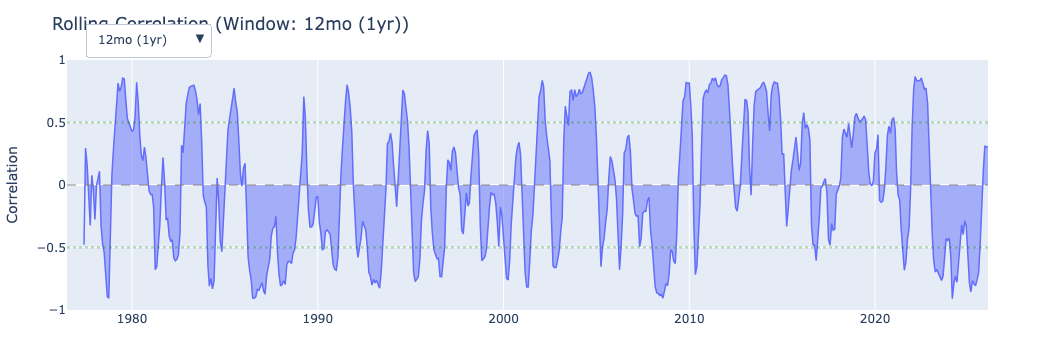

In [6]:
# Interactive rolling correlation with dropdown for window size
windows = [6, 12, 24, 36, 60, 120]  # 6mo, 1yr, 2yr, 3yr, 5yr, 10yr

fig_corr = go.Figure()

for i, w in enumerate(windows):
    rc = combined['NASDAQ 6M %'].rolling(w).corr(combined['Yield Spread'])
    fig_corr.add_trace(
        go.Scatter(
            x=rc.index, y=rc.values,
            name=f'{w} months',
            visible=(w == 12),
            line=dict(width=1.5),
            fill='tozeroy',
            hovertemplate='%{x|%b %Y}<br>Correlation: %{y:.3f}<extra></extra>'
        )
    )

# Create dropdown buttons
buttons = []
labels = ['6mo', '12mo (1yr)', '24mo (2yr)', '36mo (3yr)', '60mo (5yr)', '120mo (10yr)']
for i, (w, label) in enumerate(zip(windows, labels)):
    visibility = [j == i for j in range(len(windows))]
    buttons.append(
        dict(label=label,
             method='update',
             args=[{'visible': visibility},
                   {'title': f'Rolling Correlation (Window: {label})'}])
    )

fig_corr.update_layout(
    title='Rolling Correlation (Window: 12mo (1yr))',
    yaxis_title='Correlation',
    yaxis_range=[-1, 1],
    height=350,
    margin=dict(t=60, l=50, r=50, b=40),
    hovermode='x unified',
    updatemenus=[
        dict(
            active=1,
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.02,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ]
)

fig_corr.update_xaxes(nticks=6, tickformat="%Y", hoverformat='%b %Y')
fig_corr.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig_corr.add_hline(y=0.5, line_dash="dot", line_color="green", opacity=0.3)
fig_corr.add_hline(y=-0.5, line_dash="dot", line_color="green", opacity=0.3)

fig_corr.show()